In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

P = [200, 3, 1000, 1000]
Q = [100, 1, 500, 500]
V = [300, 6, 1500, 1500]
WEIGHTS = [4, 4, 2, 3]

type = ['cost', 'gain', 'cost', 'cost']

In [2]:
filename = 'data.csv'

data = pd.read_csv(filename, sep=',')
data.pop('Lp.')
data

,Cena,Metraż,Odległość na uczelnię,Odległość do pracy
0,1100,19,3400,6700
1,900,10,7700,11600
2,700,9,5400,6100
3,1600,14,1600,5100
4,1000,11,4000,8600
5,1300,16,3200,800
6,1800,30,3400,6700
7,850,12,5500,6500
8,1450,11,4500,2400
9,900,9,4700,2000


In [3]:
def cost_type_preference(a, b, p, q):
        # Funkcja preferencji dla kryterium typu koszt
        if b - a > p:
            return 1
        elif b - a <= q:
            return 0
        else:
            return (b - a - q) / (p - q)

def gain_type_preference(a, b, p, q):
        # Funkcja preferencji dla kryterium typu zysk
        if a - b > p:
            return 1
        elif a - b <= q:
            return 0
        else:
            return (a - b - q) / (p - q)

def calculate_marginal_preference_indices(data, col_index, col_name, type, P, Q):
    result = []
    if type[col_index] == 'gain':
        for value1 in data[col_name]: 
            result_row = []
            for value2 in data[col_name]:
                result_row.append(gain_type_preference(value1, value2, P[col_index], Q[col_index]))
            result.append(result_row)
    else:
        for value1 in data[col_name]: 
            result_row = []
            for value2 in data[col_name]:
                result_row.append(cost_type_preference(value1, value2, P[col_index], Q[col_index]))
            result.append(result_row)
    return result

def aggregated_marginal_preference_indices(data, type, P, Q):
    matrices = []
    for col_index, col_name in enumerate(data):
        matrices.append(calculate_marginal_preference_indices(data, col_index, col_name, type, P, Q))
    return matrices

def comprehensive_preference_index(pi_matrices, weights):
    result = np.zeros_like(pi_matrices[0] , dtype=float)
    total_weight = sum(weights)
    
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            weighted_sum = 0
            for k, matrix in enumerate(pi_matrices):
                weighted_sum += matrix[i][j] * weights[k]
            result[i][j] = weighted_sum / total_weight
    
    return result

def calculate_phi_positive_rank(row_sums):
    phi_positive_dict = {index: round(value,2) for index, value in enumerate(row_sums)}
    phi_positive_rank = {index: value for index, value in sorted(phi_positive_dict.items(), key=lambda x: x[1], reverse=True)}
    return phi_positive_rank

def calculate_phi_negative_rank(col_sums):
    phi_negative_dict = {index: round(value,2) for index, value in enumerate(col_sums)}
    phi_negative_rank = {index: value for index, value in sorted(phi_negative_dict.items(), key=lambda x: x[1], reverse=False)}
    return phi_negative_rank

def show_rank(rank):
    indices_rank = rank.keys()
    arrow_notation = " -> ".join(map(str, indices_rank))
    print(arrow_notation)
    return

def promethee_2(phi_positive, phi_negative):   
    phi = phi_positive - phi_negative
    phi_dict = {index: round(value, 2) for index, value in enumerate(phi)}
    phi_rank = {index: value for index, value in sorted(phi_dict.items(), key=lambda x: x[1], reverse=True)}
    return phi_rank

# określ relację pomiędzy dwoma wariantami
def compare_indices(index_a, index_b, phi_plus, phi_minus):
    phi_plus_a = phi_plus[index_a]
    phi_plus_b = phi_plus[index_b]
    phi_minus_a = phi_minus[index_a]
    phi_minus_b = phi_minus[index_b]

    # preferencja
    if phi_plus_a > phi_plus_b and phi_minus_a < phi_minus_b:
        return "preference"
    elif phi_plus_a == phi_plus_b and phi_minus_a < phi_minus_b:
        return "preference"
    elif phi_plus_a > phi_plus_b and phi_minus_a == phi_minus_b:
        return "preference"
    
    # nierozróżnialność
    elif phi_plus_a == phi_plus_b and phi_minus_a == phi_minus_b:
        return "indifference"
    
    # nieporównywalność
    elif (phi_plus_a > phi_plus_b and phi_minus_a > phi_minus_b) or \
         (phi_plus_a < phi_plus_b and phi_minus_a < phi_minus_b):
        return "incomparability"
    
    return

# porównaj wszystkie warianty między sobą
def compare_all_indices(phi_plus, phi_minus):
    results = {i: {'preferred': [], 'indifferent': [], 'incomparable': []} for i in range(len(phi_plus))}
    for i in range(len(phi_plus)):
        for j in range(len(phi_plus)):
            if i == j:
                continue
            result = compare_indices(i, j, phi_plus, phi_minus)
            if result == "preference":
                results[i]['preferred'].append(j)
            elif result == "indifference":
                results[i]['indifferent'].append(j)
            elif result == "incomparability":
                results[i]['incomparable'].append(j)
    return results

In [4]:
# oblicz preferencje cząstkowe na każdym z kryteriów
pi_matrices = aggregated_marginal_preference_indices(data, type, P, Q)

# oblicz globalny współczynnik preferencji
result_matrix = comprehensive_preference_index(pi_matrices, WEIGHTS)
    
# przepływ pozytywny dla każdego wariantu
phi_positive = result_matrix.sum(axis=1)

# przepływ negatywny dla każdego wariantu
phi_negative = result_matrix.sum(axis=0)

# posortuj przepływy
phi_positive_rank = calculate_phi_positive_rank(phi_positive)
phi_negative_rank = calculate_phi_negative_rank(phi_negative)

# wyświetl rankingi przepływów dodatnich i ujemnych
print("Przepływ dodatni:")
show_rank(phi_positive_rank)
print("Przepływ ujemny:")
show_rank(phi_negative_rank)

Przepływ dodatni:
17 -> 5 -> 11 -> 18 -> 10 -> 0 -> 16 -> 14 -> 12 -> 3 -> 6 -> 9 -> 2 -> 13 -> 19 -> 7 -> 8 -> 4 -> 15 -> 1
Przepływ ujemny:
16 -> 10 -> 5 -> 18 -> 9 -> 11 -> 19 -> 0 -> 13 -> 17 -> 14 -> 7 -> 12 -> 3 -> 2 -> 6 -> 8 -> 4 -> 15 -> 1


Ranking PROMETHEE I:
1. [5, 10, 16, 17]
2. [11, 18]
3. [0, 9]
4. [14, 13, 19]
5. [12, 7]
6. [3]
7. [2, 6]
8. [8]
9. [4]
10. [15]
11. [1]


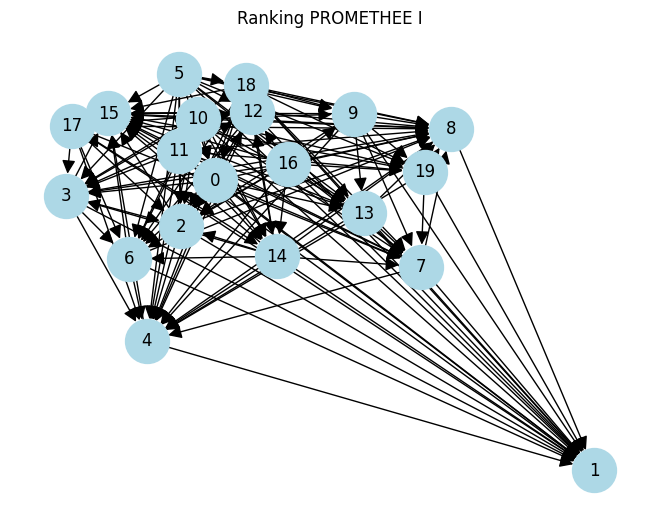

In [5]:
# PROMETHEE I

# znajdź relacje preferencji, nierozróżnialności i nieporównywalności
relations = compare_all_indices(phi_positive_rank, phi_negative_rank)

# stworzenie grafu
G = nx.DiGraph()
for index, comparison in relations.items():
    preferred = comparison['preferred']
    incomparable = comparison['incomparable']
    for pref_index in preferred:
        G.add_edge(index, pref_index)

# obliczenie rankingu na podstawie grafu
ranking = list(nx.topological_sort(G))

# pogrupowanie nieporównywalnych elementów
incomparable_groups = []
for node in ranking:
    found_group = False
    for group in incomparable_groups:
        if all(idx in relations[node]['incomparable'] for idx in group):
            group.append(node)
            found_group = True
            break
    if not found_group:
        incomparable_groups.append([node])

# wyświetlenie rankingu
print("Ranking PROMETHEE I:")
for i, group in enumerate(incomparable_groups, 1):
    print(f"{i}. {group}")

# wyświetlenie rankingu
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, arrowsize=20)
plt.title('Ranking PROMETHEE I')
plt.show()

In [6]:
# PROMETHEE II

# skonstruuj ranking PROMETHEE II
rank_promethee_2 = promethee_2(phi_positive, phi_negative)

# wyświetl ranking PROMETHEE II
print('Ranking PROMETHEE II:')
show_rank(rank_promethee_2)

Ranking PROMETHEE II:
5 -> 16 -> 10 -> 17 -> 11 -> 18 -> 0 -> 9 -> 14 -> 12 -> 3 -> 19 -> 13 -> 6 -> 7 -> 2 -> 8 -> 4 -> 15 -> 1


# ELECTRE III


In [7]:
import pandas as pd
import numpy as np


class ELECTRE:
    def __init__(self):
        self.data = None
        self.c = None
        self.D = None
        self.C = None
        self.sigma = None
        self.ranking_descending = {}
        self.ranking_ascending = {}
        self.median_ranking = {}

    
    def load_data(self, filename):
        data = pd.read_csv(filename, sep=',')
        data.pop('Lp.')
        self.data = data

    
    def gain_type_concordance(self, a, b, p, q):
        # Współczynnik zgodności dla kryterium typu zysk
        if a - b >= -q:
            return 1
        elif a - b < -p:
            return 0
        else:
            return (p - (b - a))  / (p - q)
        
    
    def cost_type_concordance(self, a, b, p, q):
        # Współczynnik zgodności dla kryterium typu koszt
        if a - b <= q:
            return 1
        elif a - b > p:
            return 0
        else:
            return (p - (a - b)) / (p - q)
        

    def gain_type_discordance(self, a, b, p, v):
        # Współczynnik niezgodności dla kryterium typu zysk
        if a - b <= -v:
            return 1
        elif a - b >= -p:
            return 0
        else:
            return ((b - a) - p)  / (v - p)
    

    def cost_type_discordance(self, a, b, p, v):
        # Współczynnik niezgodności dla kryterium typu koszt
        if a - b >= v:
            return 1
        elif a - b <= p:
            return 0
        else:
            return (v - (a - b)) / (v - p)
        

    def count_marginal_concordace(self, p, q):
        struct = np.zeros((self.data.shape[0], self.data.shape[0], self.data.shape[1]))

        for i, a in enumerate(self.data.values):
            for j, b in enumerate(self.data.values):
                if i == j:
                    struct[i, j, :] = 1
                    continue
                for k, g in enumerate(a):
                    if k != 1:
                        struct[i, j, k] = self.gain_type_concordance(g, b[k], p[k], q[k])
                    else:
                        struct[i, j, k] = self.cost_type_concordance(g, b[k], p[k], q[k])

        self.c = struct


    def count_marginal_discordace(self, p, v):
        struct = np.zeros((self.data.shape[0], self.data.shape[0], self.data.shape[1]))

        for i, a in enumerate(self.data.values):
            for j, b in enumerate(self.data.values):
                if i == j:
                    struct[i, j, :] = 0
                    continue
                for k, g in enumerate(a):
                    if k != 1:
                        struct[i, j, k] = self.gain_type_discordance(g, b[k], p[k], v[k]) if self.c[i, j, k] == 0 else 0
                    else:
                        struct[i, j, k] = self.cost_type_discordance(g, b[k], p[k], v[k]) if self.c[i, j, k] == 0 else 0

        self.D = struct


    def count_total_concordance(self, w):
        self.C =  np.sum(self.c * w, axis=2) / np.sum(w)
        

    def count_outranking_credibility(self):
        struct = np.zeros_like(self.C)
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[0]):
                f = np.where(self.D[i, j, :] > self.C[i, j])
                if len(f[0]) == 0:
                    struct[i, j] = self.C[i, j]
                else:
                    if np.any(self.D[i, j, f] == 1):
                        struct[i, j] = 0
                    else:
                        struct[i, j] = self.C[i, j] * np.prod((1 - self.D[i, j, f]) / (1 - self.C[i, j]))

        self.sigma = struct

    
    def destilation(self, descending):
        
        # Definicja funkcji S
        s = lambda x: -0.15 * x + 0.3

        # dla ułatwienia implementacji signorowania wartości po przekątnych wypełniam ich wartości zerami
        np.fill_diagonal(self.sigma, 0)

        # do macierzy sigma dołączam indeksy wierszy
        sigma = self.sigma.copy()
        indices = np.arange(0, self.sigma.shape[0], dtype=int)
        sigma = np.c_[sigma, indices]
        
        # numer iteracji, reprezentuje również miejsce w rankingu
        place = 1


        while sigma.size != 0:
            # poszukiwanie górnego progu wiarygodności
            lambda_upper = np.max(sigma[:,:-1])

            # jeżeli jest równy 0 to kończę wykonywanie algorytmu
            if lambda_upper == 0:
                if descending:
                    self.ranking_descending[place] = sigma[:,-1]
                else:
                    self.ranking_ascending[place] = sigma[:,-1]
                break

            # poszukiwanie dolnego progu wiarygodności
            lambda_lower = np.max(sigma[:,:-1][
                np.where(sigma[:,:-1] < lambda_upper - s(lambda_upper))
            ])

            # zapisywanie wartości sigma dla par gdzie A jest preferowane nad B
            checklist = np.where((sigma[:,:-1] > lambda_lower) & (sigma[:,:-1] > sigma[:,:-1].T + s(sigma[:,:-1])), sigma[:,:-1], 0)

            # obliczam siłę i słabość wariantów oraz ich użyteczność
            strength = np.count_nonzero(checklist, axis=1)
            weakness = np.count_nonzero(checklist, axis=0)
            quality = strength - weakness

            # zapisuję indeksy najlepszych wariantów
            if descending:
                best_alternatives = np.where(quality == np.max(quality))[0]
            else:
                best_alternatives = np.where(quality == np.min(quality))[0]
            idxs = np.array(sigma[best_alternatives, -1])
        
            # jeżeli dojdzie do remisu to przechodzę do destylacji wewnętrznej
            while idxs.size != 1:
                initial_destilation = sigma[best_alternatives,:-1]
                initial_destilation = initial_destilation[:, best_alternatives]

                lambda_upper = lambda_lower

                if lambda_upper == 0:
                    break
                
                try:
                    lambda_lower = np.max(initial_destilation[
                        np.where(initial_destilation < lambda_upper - s(lambda_upper))
                    ])
                except ValueError:
                    lambda_lower = 0

                checklist = np.where((initial_destilation > lambda_lower) & (initial_destilation > initial_destilation.T + s(initial_destilation)), initial_destilation, 0)
                #print(checklist)
                strength = np.count_nonzero(initial_destilation, axis=0)
                weakness = np.count_nonzero(initial_destilation, axis=1)
                quality = strength - weakness

                if descending:
                    best_alternatives = np.where(quality == np.max(quality))[0]
                else:
                    best_alternatives = np.where(quality == np.min(quality))[0]
                idxs = idxs[best_alternatives]

            # przypisuję wariantom miejsce w rankingu
            if descending:
                self.ranking_descending[place] = idxs
            else:
                self.ranking_ascending[place] = idxs
            
            # usuwam warianty z macierzy sigma
            for i in idxs:
                indices = indices[indices != i]
            
            for idx in idxs:
                row_to_delete = np.where(sigma[:,-1] == idx)[0]
                for i in range(2):
                    sigma = np.delete(sigma, row_to_delete, axis=i)

            place += 1


    def reverse_ranking(self):
        keys = list(self.ranking_descending.keys())
        values = list(self.ranking_descending.values())
        for k, v in zip(keys[::-1], values):
            self.ranking_descending[k] = v


    def create_median_ranking(self):
        path_length = {}
        for alt in np.arange(0, self.data.shape[0]):
            for k in self.ranking_descending.keys():
                if alt in self.ranking_descending[k]:
                    desc_path = k
                    break
            for k in self.ranking_ascending.keys():
                if alt in self.ranking_ascending[k]:
                    asc_path = k
                    break
            if desc_path + asc_path not in path_length.keys():
                path_length[desc_path + asc_path] = [alt]
            else:
                path_length[desc_path + asc_path].append(alt)            
        
        path_length = dict(sorted(path_length.items()))

        self.median_ranking = {k+1: v for k, v in zip(range(len(path_length)), path_length.values())}             



In [8]:
P = [200, 3, 1000, 1000]
Q = [100, 1, 500, 500]
V = [300, 6, 1500, 1500]
WEIGHTS = [4, 4, 2, 3]

electre = ELECTRE()
electre.load_data(filename)
electre.count_marginal_concordace(P, Q)
electre.count_marginal_discordace(P, V)
electre.count_total_concordance(WEIGHTS)
electre.count_outranking_credibility()
electre.destilation(descending=True)
electre.destilation(descending=False)
electre.reverse_ranking()
electre.create_median_ranking()
print(electre.median_ranking)

{1: [5, 10, 11, 16], 2: [9], 3: [0], 4: [3, 19], 5: [2, 6, 7, 13, 17], 6: [18], 7: [12, 14], 8: [4], 9: [8, 15], 10: [1]}
